<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation for Binary MNIST Model using RISE

This notebook demonstrates how to apply the RISE explainability method on a pretrained binary MNIST model using a hand-written digit image. It visualizes the relevance attributions for each pixel/super-pixel by displaying them on top of the input image.<br>

RISE is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>

More details about this method can be found in the paper https://arxiv.org/abs/1806.07421.<br>

In [49]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import dianna
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.special import softmax
from dianna import visualization

#### 1 - Loading the model and the dataset
Loads pretrained binary MNIST model and the image to be explained.

Load saved binary MNIST data.

In [50]:
# load dataset
data = np.load('./data/binary-mnist.npz')
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 1, 28, 28])
y_test = data['y_test']

In [43]:
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1]) / 255
print(X_test[3].shape)

(28, 28, 1)


In [44]:
from PIL import Image, ImageStat

def open_image(path):
    im = Image.open(path).convert("RGB")
    stat = ImageStat.Stat(im)
    im = np.asarray(im).astype(np.float32)

    if sum(stat.sum)/3 == stat.sum[0]: #check the avg with any element value
        return np.expand_dims(im[:,:,0], axis=2) / 255 #if grayscale
    else:
        return im #else its colour

path_colour = './img/bee.jpg'
path_gray = '../dashboard/app_data/digit0.jpg'

In [48]:
X_test.shape[2]

1

In [45]:
X_test = open_image(path_gray)
print(X_test.shape)

(28, 28, 1)


In [40]:
# Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()

fig.add_trace(go.Heatmap(z=X_test[:,:,0], colorscale='gray', showscale=False))

fig.update_layout(
    width=300,
    height=300)

fig.update_xaxes(showgrid = False, showticklabels = False, zeroline=False)
fig.update_yaxes(showgrid = False, showticklabels = False, zeroline=False)

Load the pretrained binary MNIST model and define a model runner.

In [51]:
def run_model(data):
    fname = './models/mnist_model.onnx'
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    
    onnx_input = {input_name: data}
    pred_onnx = sess.run([output_name], onnx_input)
    
    return softmax(pred_onnx[0], axis=1)

pred_onnx = run_model(X_test)

Print class and image of a single instance in the test data for preview.

The predicted class is: digit 0


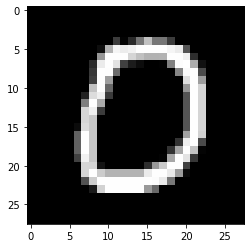

In [52]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 3
# predicted class
pred_class = class_name[np.argmax(pred_onnx[i_instance])]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][0], cmap='gray')  # 0 for channel

In [55]:
len(pred_onnx[3])

2

In [56]:
import onnx
import onnxruntime
from onnx_tf.backend import prepare
X_test = open_image(path_gray)

onnx_model = onnx.load('./models/mnist_model_tf.onnx')
                # get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]
predictions = prepare(onnx_model).run(X_test[None, ...])[f'{output_node}']

2022-04-04 17:51:15.613264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-04 17:51:15.613395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-04-04 17:51:17.959466: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-04 17:51:17.959520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [62]:
len(predictions[0])

2

In [ ]:
fig.update_layout(
    paper_bgcolor=layouts.colors['blue4'],
    plot_bgcolor = layouts.colors['blue4'])
fig.update_xaxes(gridcolor = layouts.colors['blue4'], showticklabels = False, zerolinecolor=layouts.colors['blue4'])
fig.update_yaxes(gridcolor = layouts.colors['blue4'], showticklabels = False, zerolinecolor=layouts.colors['blue4'])


In [67]:
fig = go.Figure()

#fig.add_trace(go.Heatmap(z=X_test[:,:,0], colorscale='gray', showscale=False))

fig.update_layout(
    paper_bgcolor='#E4F3F9',
    plot_bgcolor = '#E4F3F9')

fig.update_layout(
    annotations = [
                {   
                    "text": "Please select v and m",
                    "xref": "paper",
                    "yref": "paper",
                    "showarrow": False,
                    "font": {
                        "size": 28
                    }
                }
            ],
    width=300,
    height=300)

fig.update_xaxes(showgrid = False, showticklabels = False, zeroline=False)
fig.update_yaxes(showgrid = False, showticklabels = False, zeroline=False)

fig.show()

ValueError: 
    Invalid element(s) received for the 'annotations' property of layout
        Invalid elements include: ['bla']

    The 'annotations' property is a tuple of instances of
    Annotation that may be specified as:
      - A list or tuple of instances of plotly.graph_objs.layout.Annotation
      - A list or tuple of dicts of string/value properties that
        will be passed to the Annotation constructor

        Supported dict properties:
            
            align
                Sets the horizontal alignment of the `text`
                within the box. Has an effect only if `text`
                spans two or more lines (i.e. `text` contains
                one or more <br> HTML tags) or if an explicit
                width is set to override the text width.
            arrowcolor
                Sets the color of the annotation arrow.
            arrowhead
                Sets the end annotation arrow head style.
            arrowside
                Sets the annotation arrow head position.
            arrowsize
                Sets the size of the end annotation arrow head,
                relative to `arrowwidth`. A value of 1
                (default) gives a head about 3x as wide as the
                line.
            arrowwidth
                Sets the width (in px) of annotation arrow
                line.
            ax
                Sets the x component of the arrow tail about
                the arrow head. If `axref` is `pixel`, a
                positive (negative) component corresponds to an
                arrow pointing from right to left (left to
                right). If `axref` is not `pixel` and is
                exactly the same as `xref`, this is an absolute
                value on that axis, like `x`, specified in the
                same coordinates as `xref`.
            axref
                Indicates in what coordinates the tail of the
                annotation (ax,ay) is specified. If set to a ax
                axis id (e.g. "ax" or "ax2"), the `ax` position
                refers to a ax coordinate. If set to "paper",
                the `ax` position refers to the distance from
                the left of the plotting area in normalized
                coordinates where 0 (1) corresponds to the left
                (right). If set to a ax axis ID followed by
                "domain" (separated by a space), the position
                behaves like for "paper", but refers to the
                distance in fractions of the domain length from
                the left of the domain of that axis: e.g., *ax2
                domain* refers to the domain of the second ax
                axis and a ax position of 0.5 refers to the
                point between the left and the right of the
                domain of the second ax axis. In order for
                absolute positioning of the arrow to work,
                "axref" must be exactly the same as "xref",
                otherwise "axref" will revert to "pixel"
                (explained next). For relative positioning,
                "axref" can be set to "pixel", in which case
                the "ax" value is specified in pixels relative
                to "x". Absolute positioning is useful for
                trendline annotations which should continue to
                indicate the correct trend when zoomed.
                Relative positioning is useful for specifying
                the text offset for an annotated point.
            ay
                Sets the y component of the arrow tail about
                the arrow head. If `ayref` is `pixel`, a
                positive (negative) component corresponds to an
                arrow pointing from bottom to top (top to
                bottom). If `ayref` is not `pixel` and is
                exactly the same as `yref`, this is an absolute
                value on that axis, like `y`, specified in the
                same coordinates as `yref`.
            ayref
                Indicates in what coordinates the tail of the
                annotation (ax,ay) is specified. If set to a ay
                axis id (e.g. "ay" or "ay2"), the `ay` position
                refers to a ay coordinate. If set to "paper",
                the `ay` position refers to the distance from
                the bottom of the plotting area in normalized
                coordinates where 0 (1) corresponds to the
                bottom (top). If set to a ay axis ID followed
                by "domain" (separated by a space), the
                position behaves like for "paper", but refers
                to the distance in fractions of the domain
                length from the bottom of the domain of that
                axis: e.g., *ay2 domain* refers to the domain
                of the second ay  axis and a ay position of 0.5
                refers to the point between the bottom and the
                top of the domain of the second ay axis. In
                order for absolute positioning of the arrow to
                work, "ayref" must be exactly the same as
                "yref", otherwise "ayref" will revert to
                "pixel" (explained next). For relative
                positioning, "ayref" can be set to "pixel", in
                which case the "ay" value is specified in
                pixels relative to "y". Absolute positioning is
                useful for trendline annotations which should
                continue to indicate the correct trend when
                zoomed. Relative positioning is useful for
                specifying the text offset for an annotated
                point.
            bgcolor
                Sets the background color of the annotation.
            bordercolor
                Sets the color of the border enclosing the
                annotation `text`.
            borderpad
                Sets the padding (in px) between the `text` and
                the enclosing border.
            borderwidth
                Sets the width (in px) of the border enclosing
                the annotation `text`.
            captureevents
                Determines whether the annotation text box
                captures mouse move and click events, or allows
                those events to pass through to data points in
                the plot that may be behind the annotation. By
                default `captureevents` is False unless
                `hovertext` is provided. If you use the event
                `plotly_clickannotation` without `hovertext`
                you must explicitly enable `captureevents`.
            clicktoshow
                Makes this annotation respond to clicks on the
                plot. If you click a data point that exactly
                matches the `x` and `y` values of this
                annotation, and it is hidden (visible: false),
                it will appear. In "onoff" mode, you must click
                the same point again to make it disappear, so
                if you click multiple points, you can show
                multiple annotations. In "onout" mode, a click
                anywhere else in the plot (on another data
                point or not) will hide this annotation. If you
                need to show/hide this annotation in response
                to different `x` or `y` values, you can set
                `xclick` and/or `yclick`. This is useful for
                example to label the side of a bar. To label
                markers though, `standoff` is preferred over
                `xclick` and `yclick`.
            font
                Sets the annotation text font.
            height
                Sets an explicit height for the text box. null
                (default) lets the text set the box height.
                Taller text will be clipped.
            hoverlabel
                :class:`plotly.graph_objects.layout.annotation.
                Hoverlabel` instance or dict with compatible
                properties
            hovertext
                Sets text to appear when hovering over this
                annotation. If omitted or blank, no hover label
                will appear.
            name
                When used in a template, named items are
                created in the output figure in addition to any
                items the figure already has in this array. You
                can modify these items in the output figure by
                making your own item with `templateitemname`
                matching this `name` alongside your
                modifications (including `visible: false` or
                `enabled: false` to hide it). Has no effect
                outside of a template.
            opacity
                Sets the opacity of the annotation (text +
                arrow).
            showarrow
                Determines whether or not the annotation is
                drawn with an arrow. If True, `text` is placed
                near the arrow's tail. If False, `text` lines
                up with the `x` and `y` provided.
            standoff
                Sets a distance, in pixels, to move the end
                arrowhead away from the position it is pointing
                at, for example to point at the edge of a
                marker independent of zoom. Note that this
                shortens the arrow from the `ax` / `ay` vector,
                in contrast to `xshift` / `yshift` which moves
                everything by this amount.
            startarrowhead
                Sets the start annotation arrow head style.
            startarrowsize
                Sets the size of the start annotation arrow
                head, relative to `arrowwidth`. A value of 1
                (default) gives a head about 3x as wide as the
                line.
            startstandoff
                Sets a distance, in pixels, to move the start
                arrowhead away from the position it is pointing
                at, for example to point at the edge of a
                marker independent of zoom. Note that this
                shortens the arrow from the `ax` / `ay` vector,
                in contrast to `xshift` / `yshift` which moves
                everything by this amount.
            templateitemname
                Used to refer to a named item in this array in
                the template. Named items from the template
                will be created even without a matching item in
                the input figure, but you can modify one by
                making an item with `templateitemname` matching
                its `name`, alongside your modifications
                (including `visible: false` or `enabled: false`
                to hide it). If there is no template or no
                matching item, this item will be hidden unless
                you explicitly show it with `visible: true`.
            text
                Sets the text associated with this annotation.
                Plotly uses a subset of HTML tags to do things
                like newline (<br>), bold (<b></b>), italics
                (<i></i>), hyperlinks (<a href='...'></a>).
                Tags <em>, <sup>, <sub> <span> are also
                supported.
            textangle
                Sets the angle at which the `text` is drawn
                with respect to the horizontal.
            valign
                Sets the vertical alignment of the `text`
                within the box. Has an effect only if an
                explicit height is set to override the text
                height.
            visible
                Determines whether or not this annotation is
                visible.
            width
                Sets an explicit width for the text box. null
                (default) lets the text set the box width.
                Wider text will be clipped. There is no
                automatic wrapping; use <br> to start a new
                line.
            x
                Sets the annotation's x position. If the axis
                `type` is "log", then you must take the log of
                your desired range. If the axis `type` is
                "date", it should be date strings, like date
                data, though Date objects and unix milliseconds
                will be accepted and converted to strings. If
                the axis `type` is "category", it should be
                numbers, using the scale where each category is
                assigned a serial number from zero in the order
                it appears.
            xanchor
                Sets the text box's horizontal position anchor
                This anchor binds the `x` position to the
                "left", "center" or "right" of the annotation.
                For example, if `x` is set to 1, `xref` to
                "paper" and `xanchor` to "right" then the
                right-most portion of the annotation lines up
                with the right-most edge of the plotting area.
                If "auto", the anchor is equivalent to "center"
                for data-referenced annotations or if there is
                an arrow, whereas for paper-referenced with no
                arrow, the anchor picked corresponds to the
                closest side.
            xclick
                Toggle this annotation when clicking a data
                point whose `x` value is `xclick` rather than
                the annotation's `x` value.
            xref
                Sets the annotation's x coordinate axis. If set
                to a x axis id (e.g. "x" or "x2"), the `x`
                position refers to a x coordinate. If set to
                "paper", the `x` position refers to the
                distance from the left of the plotting area in
                normalized coordinates where 0 (1) corresponds
                to the left (right). If set to a x axis ID
                followed by "domain" (separated by a space),
                the position behaves like for "paper", but
                refers to the distance in fractions of the
                domain length from the left of the domain of
                that axis: e.g., *x2 domain* refers to the
                domain of the second x  axis and a x position
                of 0.5 refers to the point between the left and
                the right of the domain of the second x axis.
            xshift
                Shifts the position of the whole annotation and
                arrow to the right (positive) or left
                (negative) by this many pixels.
            y
                Sets the annotation's y position. If the axis
                `type` is "log", then you must take the log of
                your desired range. If the axis `type` is
                "date", it should be date strings, like date
                data, though Date objects and unix milliseconds
                will be accepted and converted to strings. If
                the axis `type` is "category", it should be
                numbers, using the scale where each category is
                assigned a serial number from zero in the order
                it appears.
            yanchor
                Sets the text box's vertical position anchor
                This anchor binds the `y` position to the
                "top", "middle" or "bottom" of the annotation.
                For example, if `y` is set to 1, `yref` to
                "paper" and `yanchor` to "top" then the top-
                most portion of the annotation lines up with
                the top-most edge of the plotting area. If
                "auto", the anchor is equivalent to "middle"
                for data-referenced annotations or if there is
                an arrow, whereas for paper-referenced with no
                arrow, the anchor picked corresponds to the
                closest side.
            yclick
                Toggle this annotation when clicking a data
                point whose `y` value is `yclick` rather than
                the annotation's `y` value.
            yref
                Sets the annotation's y coordinate axis. If set
                to a y axis id (e.g. "y" or "y2"), the `y`
                position refers to a y coordinate. If set to
                "paper", the `y` position refers to the
                distance from the bottom of the plotting area
                in normalized coordinates where 0 (1)
                corresponds to the bottom (top). If set to a y
                axis ID followed by "domain" (separated by a
                space), the position behaves like for "paper",
                but refers to the distance in fractions of the
                domain length from the bottom of the domain of
                that axis: e.g., *y2 domain* refers to the
                domain of the second y  axis and a y position
                of 0.5 refers to the point between the bottom
                and the top of the domain of the second y axis.
            yshift
                Shifts the position of the whole annotation and
                arrow up (positive) or down (negative) by this
                many pixels.


#### 2 - Compute and visualize the relevance attributions
Compute the relevance attributions using RISE and visualize them overlayed on the image. 

RISE masks random portions of the input image and passes the masked image through the model — the portion that decreases the accuracy the most is the most “important” portion.<br>
To call the explainer and generate the relevance scores, the user need to specified the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).

In [5]:
relevances = dianna.explain_image(run_model, X_test[i_instance], method="RISE",
                                labels=[i for i in range(2)],
                                n_masks=5000, feature_res=8, p_keep=.1,
                                axis_labels=('channels','height','width'))

Explaining: 100%|██████████| 50/50 [00:00<00:00, 140.13it/s]


Visualize the relevance scores for the predicted class on top of the image.

Explanation for `digit 0`


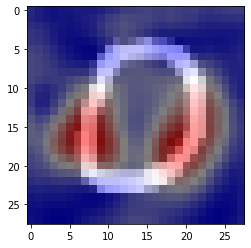

In [6]:
print(f'Explanation for `{pred_class}`')
visualization.plot_image(relevances[0], X_test[i_instance][0], data_cmap='gray', heatmap_cmap='bwr')

#### 3 - Conclusions
The relevance scores are generated by passing multiple randomly masked inputs to the black-box model and averaging their pixel relevances. The idea behind this is that whenever a mask preserves important parts of the image it gets higher score. <br>

The example here shows that the RISE method evaluates the relevance of each pixel/super pixel to the classification and highlights the lateral parts of the digit zero. This implies that the model determines whether the digit is 0 by checking the lateral parts. The results are reasonable compared to the human visual preception of the test image.